In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import pandas as pd
import numpy as np
import torch
import datetime
from tqdm import tqdm_notebook
from torch import nn
from torchvision import transforms
from cnn_finetune import make_model
from sklearn.model_selection import StratifiedKFold

import model3 as M
import unet_parts
from dataset import SegmentationDataset, SegmentationInferenceDataset
from data import *
from util import *
from loss import FocalLoss, dice_loss
from lovasz_loss import lovasz_hinge_flat, lovasz_hinge

In [3]:
torch.cuda.is_available()
device = torch.device('cuda')

In [4]:
# Settings
# ========

# Target k in KFold
CV = 3

# Skip pretraining
skip_pretraining = False

In [5]:
train_df, val_df = get_dfs_fold(k=CV)

train_dataset = SegmentationDataset(train_df, size=(128, 128),
                                    use_depth_channels=True,
                                    with_aux_label=True,
                                    as_aux_label='coverage_class',
                                    use_augmentation=True)
val_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128),
                                           use_depth_channels=True, with_aux_label=False, with_gt=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
print('Loaded dataset and created loader')

Use augmentations
Loaded dataset and created loader


# Training

In [6]:
gc.collect()
torch.cuda.empty_cache()

model = M.UNetRes34HcAuxSCSEv4(n_classes=1, n_aux_classes=8)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters())

Loaded pretrained resnet weights


In [7]:
def criterion_phase1(logit, logit_aux, target_pixel, target_label):
    segmentation_loss = F.binary_cross_entropy_with_logits(logit.view(-1), target_pixel.view(-1), size_average=True)
    segmentation_dice_loss = dice_loss(logit, target_pixel)
    
    classification_loss = F.cross_entropy(logit_aux, target_label)
    
    return 0.5 * segmentation_loss + 0.5 * segmentation_dice_loss + 0.01 * classification_loss

In [8]:
def train_phase1(model, n_epoch, train_iter, val_iter):
    best_iou = 0.0
    n_stay = 0
    early_stopping_limit = 10
    
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit, logit_aux = model(data)
            loss = criterion_phase1(logit, logit_aux, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=True, threshold=0.5)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
        
        if best_iou < iou:
            best_iou = iou
            save_model(model, f'unet_res34_hcauxscse_v4_aug_kfold_cv{CV}_phase1')
            print('Saved model at {} (IoU: {})'.format(epoch, iou))
            n_stay = 0
        else:
            n_stay += 1
        
        if n_stay >= early_stopping_limit:
            print('Early stopping at {} (Best IoU: {})'.format(epoch, best_iou))
            break
            
    return model

In [9]:
if not skip_pretraining:
    model = train_phase1(model, 50, train_loader, val_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


[2018-10-18 17:48:43.723039] Train Epoch: 0 [0/3200 (0%)]	Average loss: 0.042251
[2018-10-18 17:49:05.241680] Train Epoch: 0 [800/3200 (25%)]	Average loss: 0.035104
[2018-10-18 17:49:26.813080] Train Epoch: 0 [1600/3200 (50%)]	Average loss: 0.029318
[2018-10-18 17:49:48.445245] Train Epoch: 0 [2400/3200 (75%)]	Average loss: 0.025673
[2018-10-18 17:49:48.445245] Train Epoch: 0	IoU: 0.619625
Saved model at 0 (IoU: 0.619625)
[2018-10-18 17:50:21.674092] Train Epoch: 1 [0/3200 (0%)]	Average loss: 0.012158
[2018-10-18 17:50:43.306140] Train Epoch: 1 [800/3200 (25%)]	Average loss: 0.017816
[2018-10-18 17:51:04.883148] Train Epoch: 1 [1600/3200 (50%)]	Average loss: 0.017128
[2018-10-18 17:51:26.476044] Train Epoch: 1 [2400/3200 (75%)]	Average loss: 0.016855
[2018-10-18 17:51:26.476044] Train Epoch: 1	IoU: 0.674750
Saved model at 1 (IoU: 0.67475)
[2018-10-18 17:51:58.907389] Train Epoch: 2 [0/3200 (0%)]	Average loss: 0.015758
[2018-10-18 17:52:20.520039] Train Epoch: 2 [800/3200 (25%)]	Average

[2018-10-18 18:20:34.398337] Train Epoch: 19	IoU: 0.755000
[2018-10-18 18:21:06.493255] Train Epoch: 20 [0/3200 (0%)]	Average loss: 0.004094
[2018-10-18 18:21:28.086533] Train Epoch: 20 [800/3200 (25%)]	Average loss: 0.005889
[2018-10-18 18:21:49.740884] Train Epoch: 20 [1600/3200 (50%)]	Average loss: 0.005640
[2018-10-18 18:22:11.350015] Train Epoch: 20 [2400/3200 (75%)]	Average loss: 0.005958
[2018-10-18 18:22:11.350015] Train Epoch: 20	IoU: 0.764875
Saved model at 20 (IoU: 0.7648750000000001)
[2018-10-18 18:22:43.789946] Train Epoch: 21 [0/3200 (0%)]	Average loss: 0.002273
[2018-10-18 18:23:05.321107] Train Epoch: 21 [800/3200 (25%)]	Average loss: 0.005149
[2018-10-18 18:23:26.945428] Train Epoch: 21 [1600/3200 (50%)]	Average loss: 0.004873
[2018-10-18 18:23:48.584973] Train Epoch: 21 [2400/3200 (75%)]	Average loss: 0.004714
[2018-10-18 18:23:48.584973] Train Epoch: 21	IoU: 0.751000
[2018-10-18 18:24:20.806515] Train Epoch: 22 [0/3200 (0%)]	Average loss: 0.003278
[2018-10-18 18:24:4

[2018-10-18 18:52:55.696040] Train Epoch: 39 [2400/3200 (75%)]	Average loss: 0.002605
[2018-10-18 18:52:55.696040] Train Epoch: 39	IoU: 0.784500
[2018-10-18 18:53:27.897329] Train Epoch: 40 [0/3200 (0%)]	Average loss: 0.002033
[2018-10-18 18:53:49.473452] Train Epoch: 40 [800/3200 (25%)]	Average loss: 0.002363
[2018-10-18 18:54:11.106901] Train Epoch: 40 [1600/3200 (50%)]	Average loss: 0.002814
[2018-10-18 18:54:32.724935] Train Epoch: 40 [2400/3200 (75%)]	Average loss: 0.002733
[2018-10-18 18:54:32.724935] Train Epoch: 40	IoU: 0.790875
[2018-10-18 18:55:04.916964] Train Epoch: 41 [0/3200 (0%)]	Average loss: 0.002899
[2018-10-18 18:55:26.491062] Train Epoch: 41 [800/3200 (25%)]	Average loss: 0.002928
[2018-10-18 18:55:48.132941] Train Epoch: 41 [1600/3200 (50%)]	Average loss: 0.002918
[2018-10-18 18:56:09.712359] Train Epoch: 41 [2400/3200 (75%)]	Average loss: 0.002886
[2018-10-18 18:56:09.712359] Train Epoch: 41	IoU: 0.754375
[2018-10-18 18:56:41.851151] Train Epoch: 42 [0/3200 (0%)]	

In [10]:
def criterion_phase2(logit, logit_aux, target_pixel, target_label):
    segmentation_loss = lovasz_hinge(logit.squeeze(), target_pixel.squeeze())
    classification_loss = F.cross_entropy(logit_aux, target_label)
    
    return segmentation_loss + 0.01 * classification_loss

In [11]:
def train_phase2(model, n_epoch, train_iter, val_iter):
    best_iou = 0.0
    n_stay = 0
    early_stopping_limit = 20
    
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit, logit_aux = model(data)
            loss = criterion_phase2(logit, logit_aux, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=False, threshold=0.0)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
        
        if best_iou < iou:
            best_iou = iou
            save_model(model, f'unet_res34_hcauxscse_v4_aug_kfold_cv{CV}_phase2')
            print('Saved model at {} (IoU: {})'.format(epoch, iou))
            n_stay = 0
        else:
            n_stay += 1
        
        if n_stay >= early_stopping_limit:
            print('Early stopping at {} (Best IoU: {})'.format(epoch, best_iou))
            break
            
    return model

In [12]:
for g in optimizer.param_groups:
    g['lr'] = 0.001

In [13]:
model = train_phase2(model, 60, train_loader, val_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


[2018-10-18 19:06:24.473716] Train Epoch: 0 [0/3200 (0%)]	Average loss: 0.031550
[2018-10-18 19:06:48.070872] Train Epoch: 0 [800/3200 (25%)]	Average loss: 0.036697
[2018-10-18 19:07:11.601932] Train Epoch: 0 [1600/3200 (50%)]	Average loss: 0.040435
[2018-10-18 19:07:35.178446] Train Epoch: 0 [2400/3200 (75%)]	Average loss: 0.039394
[2018-10-18 19:07:35.178446] Train Epoch: 0	IoU: 0.790875
Saved model at 0 (IoU: 0.7908750000000001)
[2018-10-18 19:08:09.682604] Train Epoch: 1 [0/3200 (0%)]	Average loss: 0.068196
[2018-10-18 19:08:33.226383] Train Epoch: 1 [800/3200 (25%)]	Average loss: 0.032661
[2018-10-18 19:08:56.741715] Train Epoch: 1 [1600/3200 (50%)]	Average loss: 0.033865
[2018-10-18 19:09:20.256533] Train Epoch: 1 [2400/3200 (75%)]	Average loss: 0.032925
[2018-10-18 19:09:20.256533] Train Epoch: 1	IoU: 0.790750
[2018-10-18 19:09:54.302126] Train Epoch: 2 [0/3200 (0%)]	Average loss: 0.029667
[2018-10-18 19:10:17.865795] Train Epoch: 2 [800/3200 (25%)]	Average loss: 0.032017
[2018-

[2018-10-18 19:41:42.282001] Train Epoch: 20 [800/3200 (25%)]	Average loss: 0.019754
[2018-10-18 19:42:05.793824] Train Epoch: 20 [1600/3200 (50%)]	Average loss: 0.019108
[2018-10-18 19:42:29.320674] Train Epoch: 20 [2400/3200 (75%)]	Average loss: 0.018562
[2018-10-18 19:42:29.320674] Train Epoch: 20	IoU: 0.803875
[2018-10-18 19:43:03.381583] Train Epoch: 21 [0/3200 (0%)]	Average loss: 0.013848
[2018-10-18 19:43:26.928149] Train Epoch: 21 [800/3200 (25%)]	Average loss: 0.018744
[2018-10-18 19:43:50.430092] Train Epoch: 21 [1600/3200 (50%)]	Average loss: 0.018958
[2018-10-18 19:44:13.913902] Train Epoch: 21 [2400/3200 (75%)]	Average loss: 0.019068
[2018-10-18 19:44:13.913902] Train Epoch: 21	IoU: 0.803375
[2018-10-18 19:44:48.115946] Train Epoch: 22 [0/3200 (0%)]	Average loss: 0.009636
[2018-10-18 19:45:11.756957] Train Epoch: 22 [800/3200 (25%)]	Average loss: 0.022584
[2018-10-18 19:45:35.458959] Train Epoch: 22 [1600/3200 (50%)]	Average loss: 0.020880
[2018-10-18 19:45:58.956672] Trai

In [14]:
val_check_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128), with_gt=True, with_raw_input=True, use_depth_channels=True)
val_check_loader = torch.utils.data.DataLoader(val_check_dataset, batch_size=8, shuffle=False)
val_check_iter = iter(val_check_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


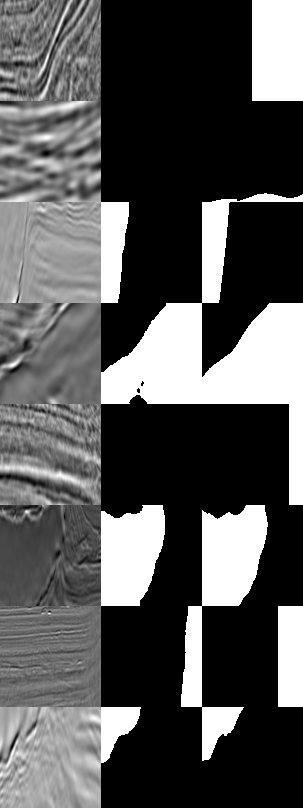

In [15]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=True, threshold=0.5)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


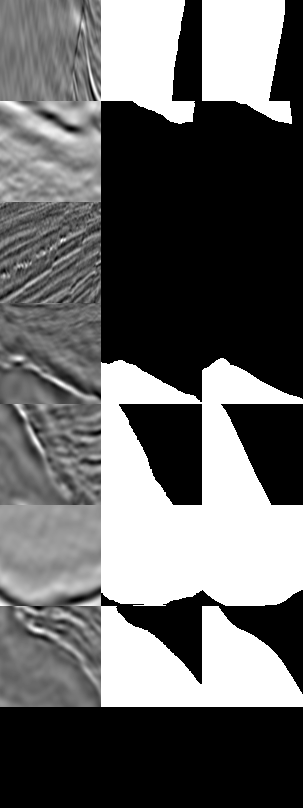

In [16]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


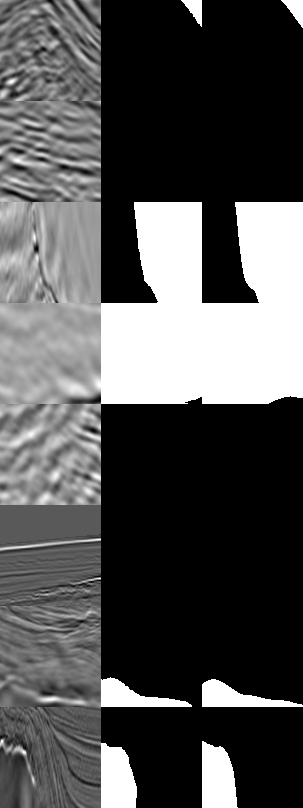

In [17]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


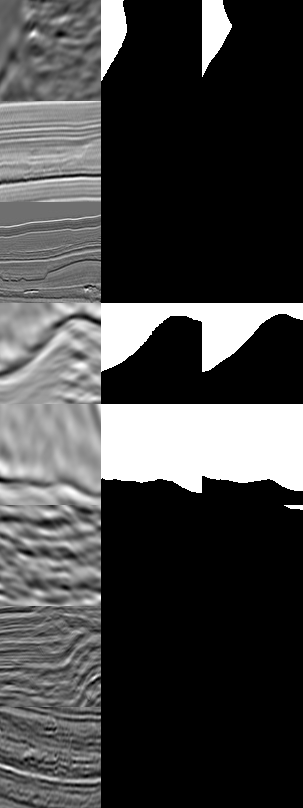

In [18]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)